Building likelihood maps for a set of representative images.

> TODO: use images from dataset and superimpose the bounding boxes on them

In [1]:
import retinoto_py as fovea
args = fovea.Params()
args

Params(image_size=224, do_mask=False, do_fovea=False, rs_min=0.0, rs_max=-7.5, padding_mode='zeros', seed=2025, batch_size=80, num_workers=1, in_memory=False, model_name='convnext_base', num_epochs=41, subset_factor=1, lr=2e-07, delta1=0.2, delta2=0.007, weight_decay=0.003, label_smoothing=0.05, shuffle=True, verbose=False)

In [2]:
import torch
from torchvision.io import read_image

In [3]:
# idx_to_label = fovea.get_idx_to_label(args)
label2idx = fovea.get_label_to_idx(args)
label2idx['impala']

Loading labels from local cache cached_data/imagenet_class_index.json...


352

In [4]:
for key in label2idx.keys(): 
    if 'wolf' in key.lower(): print(key)

wolf_spider
Irish_wolfhound
timber_wolf
white_wolf
red_wolf


In [5]:
dataset = 'bbox'
model_filename = args.data_cache / f'32_fovea_model_name={args.model_name}_dataset={dataset}.pth'
model = fovea.load_model(args, model_filename=model_filename)
model_filename

PosixPath('cached_data/32_fovea_model_name=convnext_base_dataset=bbox.pth')

type(full_image) = <class 'torch.Tensor'>, full_image.dtype = torch.float32, full_image.shape = torch.Size([3, 1024, 1395])


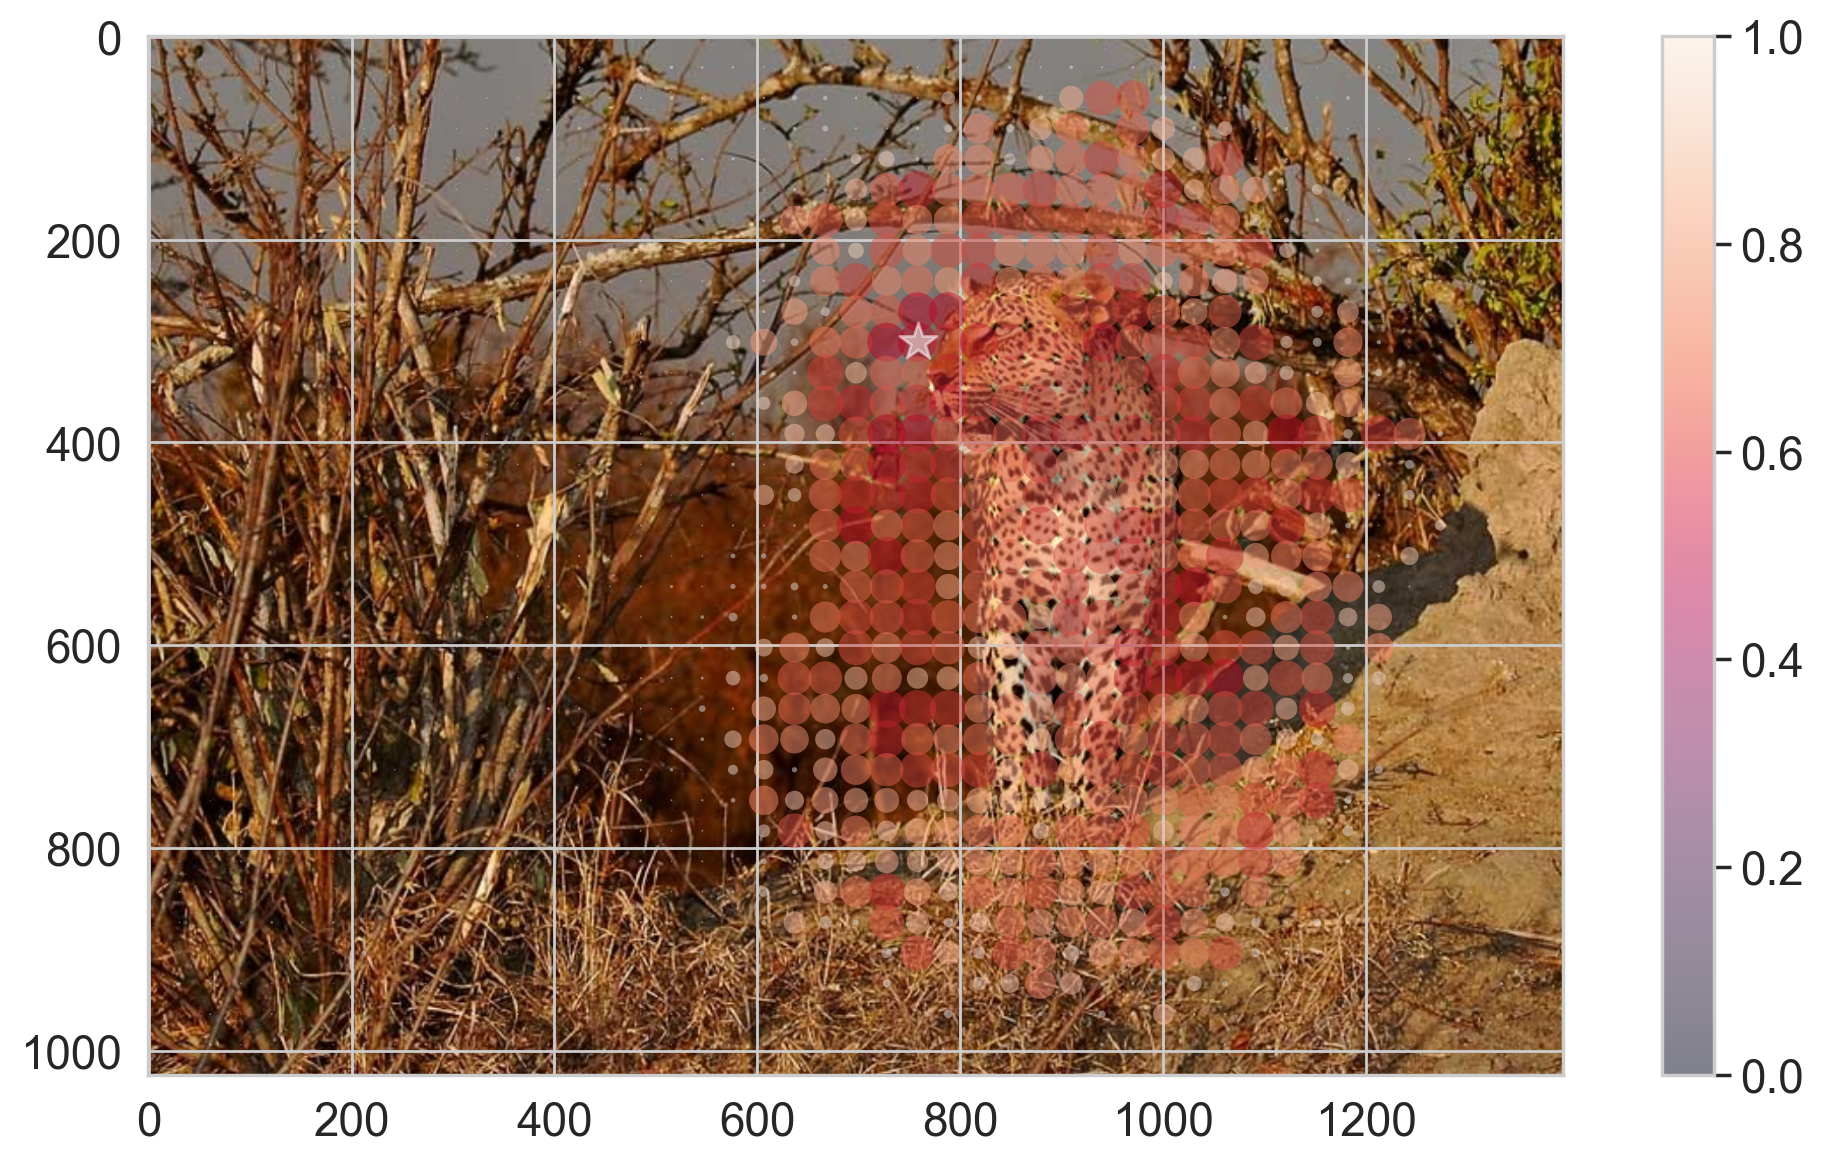

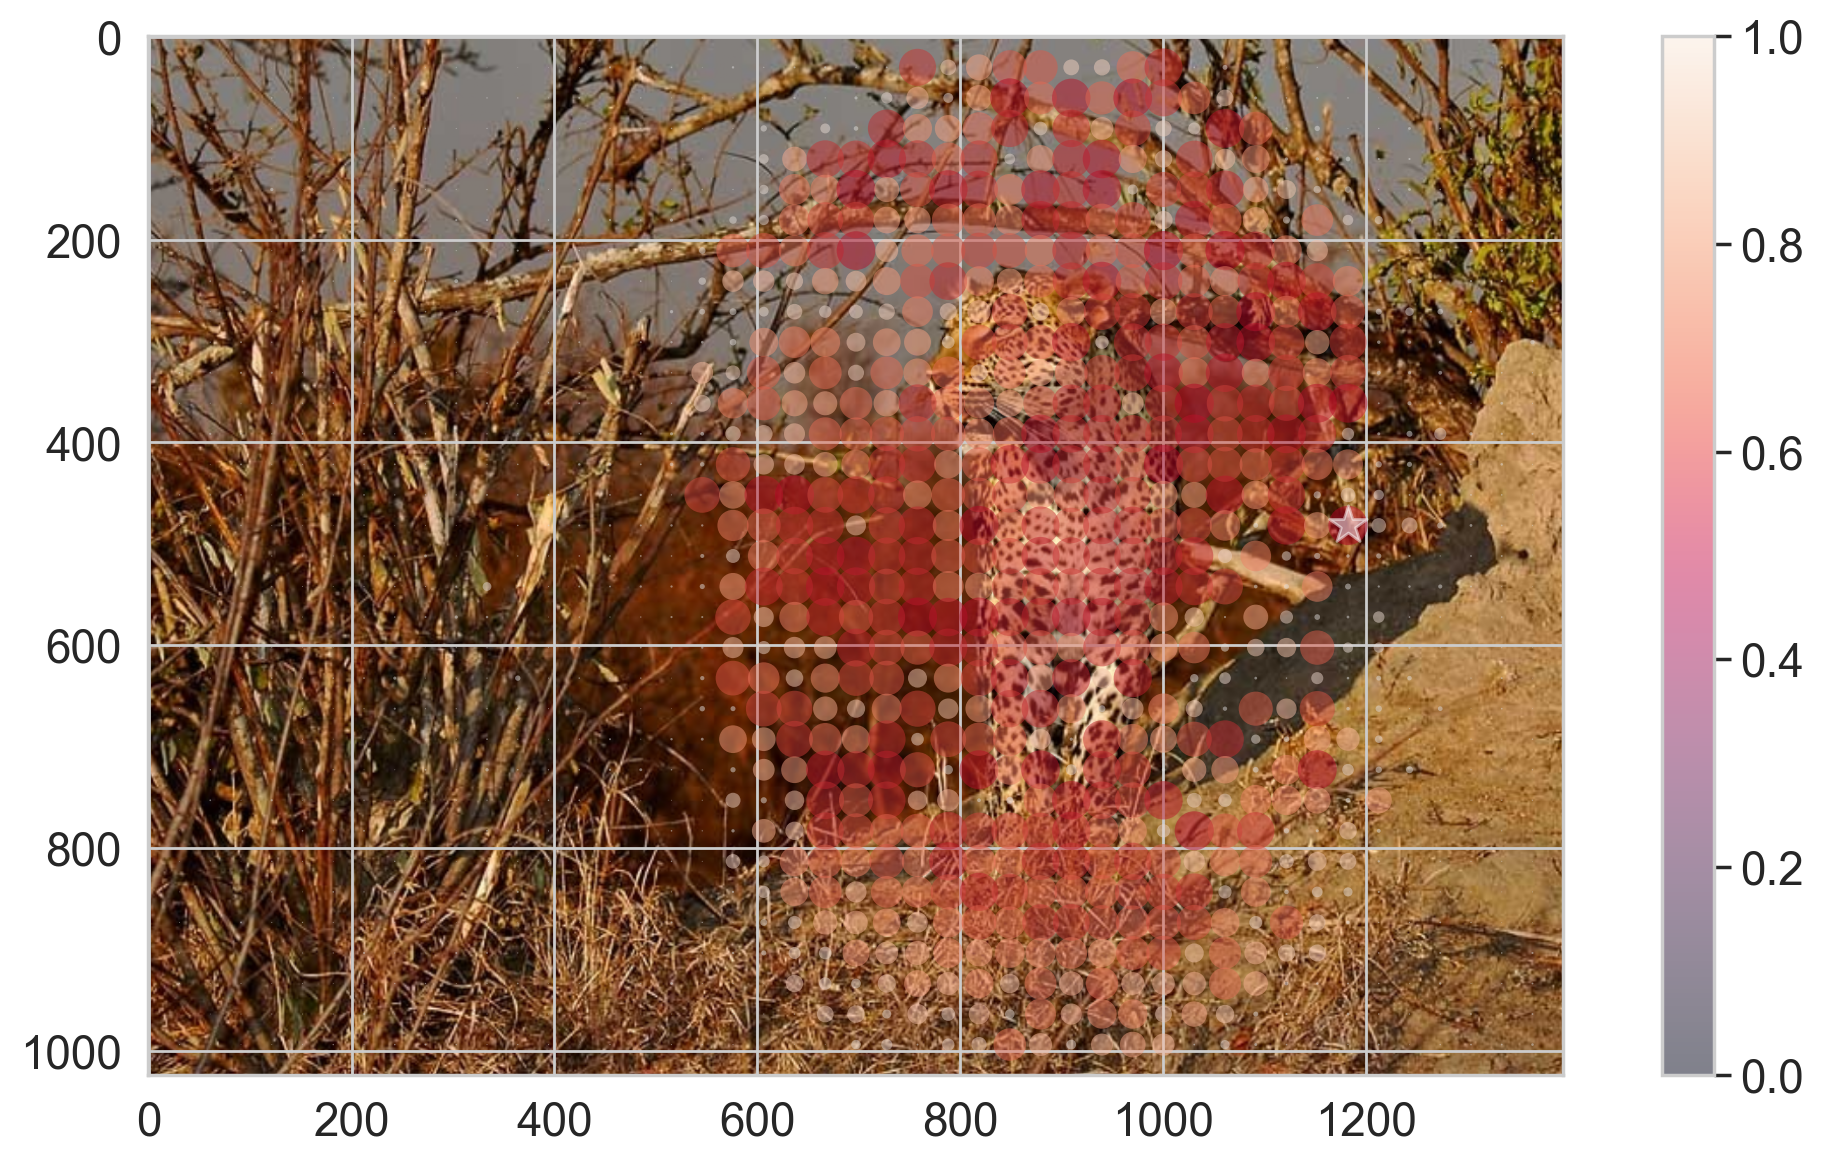

type(full_image) = <class 'torch.Tensor'>, full_image.dtype = torch.float32, full_image.shape = torch.Size([3, 1024, 1365])


In [ ]:
from torchvision.transforms.functional import InterpolationMode, resize
image_size_full = 1024
resolution = (50, 30)
size_ratio = .6
alpha = .5
s_max = 200

for image_url, true_label in  [('leopard.jpg',  'leopard'),
                                # ('wolf.jpg',  'white_wolf'),
                                ('frog.jpg',  'tree_frog'),
                                # ('Hidden_snow_leopard.png',  'snow_leopard'),
                                ('Hidden_leopard.png',  'leopard'),
                                # ('Hidden_giraffe.png',  'girafe'),
                                ('Hidden_tiger.png',  'tiger'),
                                ('Hidden_owl.png',  'great_grey_owl'),
                                ]:
    full_image = read_image('./images/' + image_url)[:3, :, :]/255
    full_image = resize(full_image, image_size_full, interpolation=InterpolationMode.BILINEAR, antialias=True)
    # print(f"{type(full_image) = }, {full_image.dtype = }, {full_image.shape = }")

    for do_fovea  in [True, False]:
        args = fovea.Params(do_mask=not(do_fovea), do_fovea=do_fovea)

        pos_H, pos_W, probas = fovea.compute_likelihood_map(args, model, full_image, size_ratio=size_ratio, resolution=resolution)
        probas = probas.cpu()
        proba_label = probas[:, label2idx[true_label]]
        idx_max = proba_label.argmax()


        fig, ax = fovea.plt.subplots()
        full_image_np = torch.movedim(full_image, (1, 2, 0), (0, 1, 2)).numpy()
        ax.imshow(full_image_np)
        ax.scatter(pos_W, pos_H, s=proba_label.abs()*s_max, c=proba_label, alpha=alpha, edgecolors='none', cmap='coolwarm', vmin=-max(abs(proba_label)), vmax=max(abs(proba_label)),)

        scatter = ax.scatter(pos_W[idx_max], pos_H[idx_max], s=proba_label[idx_max]*s_max, marker='*', c='white', alpha=alpha)
        fig.colorbar(scatter, ax=ax)  # Add colorbar

        fig.set_facecolor(color='white')
        fovea.plt.show()